In [2]:
import numpy as np
import pandas as pd
import time

In [3]:
# set random seed for reproducibility
np.random.seed(42)

In [4]:
def censored_als(X, mask, cutoffs, rank=5, niters=50, lambda_=0.2):
    """
    Alternating Least Squares algorithm for matrix factorization
    X: matrix to factorize
    mask: binary mask of observed entries, 1 for observed, 0 for unobserved
    cutoffs: matrix of cutoffs for censored entries, 0 for uncensored
    rank: rank of the factorization
    niters: number of iterations
    lambda_: regularization parameter
    """
    n, m = X.shape
    A = np.random.rand(n, rank)
    B = np.random.rand(m, rank)
    for _ in range(niters):
        target = X + (1 - mask) * (np.dot(A, B.T))
        violations = (target < cutoffs) & (cutoffs > 0)
        target[violations] = cutoffs[violations]
        A = np.linalg.solve(np.dot(B.T, B) + lambda_ * np.eye(rank), np.dot(target, B).T).T
        A[A < 0] = 0
        target = X + (1 - mask) * (np.dot(A, B.T))
        violations = (target < cutoffs) & (cutoffs > 0)
        target[violations] = cutoffs[violations]
        B = np.linalg.solve(np.dot(A.T, A) + lambda_ * np.eye(rank), np.dot(target.T, A).T).T
        B[B < 0] = 0
    
    return X + (1 - mask) * (np.dot(A, B.T))

In [5]:
# load the workload matrix, each row is a query, each column is a hint, the value is the latency of the plan
matrix = pd.read_csv("dataset/ceb-matrix.csv", index_col='filename').to_numpy()

print("matrix shape:", matrix.shape)
default_time = np.sum(matrix[:,0])
print("PG Default time(s):", default_time)
opt_time = np.sum(np.min(matrix, axis=1))
print("Optimal Hint time(s):", opt_time)

matrix shape: (3133, 49)
PG Default time(s): 10587.665450334549
Optimal Hint time(s): 3688.4883341789246


In [6]:
def get_same_hints(i, j):
    """
    Return the hint indexes that generate the same plan as the hint at (i, j)
    We check the values here, because the runtime value represents whether the plan is the same.
    """
    val = matrix[i][j]
    row = matrix[i]
    # return the indexes in the row that are the same as val
    return np.where(row == val)[0].tolist()

# get unique mask here for the whole matrix
# all unique plans are 1, all duplicates are 0
unique_mask = np.ones(matrix.shape)
for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
        if unique_mask[i][j] == 1:
            # get the indexes of the hints that are the same as val
            same_hints = get_same_hints(i, j)
            same_hints.remove(j)
            # set the mask to 0 for those indexes
            unique_mask[i][same_hints] = 0

print("unique plan percentage:", unique_mask.sum() / unique_mask.size)

unique plan percentage: 0.5467863493945296


In [7]:
def get_exec_time(mask):
    """
    Return the execution time of the matrix with the given mask
    mask: binary mask of observed entries
    """
    # multiply with the unique_mask because we don't want to compute the same plan multiple times
    observed = matrix * mask * unique_mask
    return observed.sum()

def get_min_observed(mask):
    """
    Return the minimum observed latency for each row
    mask: binary mask of observed entries
    """
    R = matrix * mask
    R[R == 0] = np.inf
    min_observed_latency = np.min(R, axis=1)
    return min_observed_latency

In [8]:
init_mask = np.load("dataset/init_ceb_mask.npy")
assert (init_mask[:,0] == 1).all()
print("The initial mask has all the first column as 1, meaning that all the default plans are observed.")

print("Init execution time(s):", get_exec_time(init_mask))

The initial mask has all the first column as 1, meaning that all the default plans are observed.
Init execution time(s): 10681.317270755768


In [12]:
def limeqo(alpha, beta, new_observe_size=8):
    mask = init_mask.copy()
    exec_time = get_exec_time(mask) - default_time
    timeout_m = np.zeros_like(matrix)
    explored_m = init_mask.copy()
    timeout = 0
    results = []
    execution_time_list = []
    total_latency_list = []
    
    while exec_time <= 3600 * 6:
        exec_time = get_exec_time(mask) + timeout - default_time
        min_observed = get_min_observed(mask)
        
        masked_m = matrix * mask
        log_m = np.log1p(masked_m)
        log_timeout_m = np.log1p(timeout_m)
        
        start_time = time.time()
        pred_m = censored_als(log_m, mask, log_timeout_m)
        training_time = time.time() - start_time
        
        pred_m = np.expm1(pred_m)
        pred_m = pred_m * (1-mask)
        pred_m[pred_m == 0] = np.inf
        start_time = time.time()
        mc_select = np.argmin(pred_m, axis=1)
        inference_time = time.time() - start_time
        
        result = {"training_time": training_time,
                "inference_time": inference_time,
                "exec_time": exec_time, 
                "total_latency": np.sum(min_observed), 
                "p50": np.median(min_observed), 
                "p90": np.percentile(min_observed, 90),}
        results.append(result)
        execution_time_list.append(exec_time)
        total_latency_list.append(np.sum(min_observed))
        print(result)
        
        mc_min = np.min(pred_m, axis=1)
        improve = (min_observed - mc_min) / mc_min
        
        selects = np.argsort(-improve)
        cnt = 0
        # select the queries with the largest predicted improvement ratio
        for select in selects:
            if cnt >= new_observe_size:
                break
            hint = mc_select[select]
            timeout_tolerance = min(alpha * min_observed[select], beta * pred_m[select, hint])
            
            # if the plan has been explored, skip
            # or if the plan has timeouted before, skip
            # or if the predicted time is larger than the timeout tolerance, skip
            if np.isinf(pred_m[select, hint]) \
                or explored_m[select, hint] != 0 \
                or pred_m[select, hint] >= timeout_tolerance:
                continue
            
            same_hints = get_same_hints(select, hint)
            
            # if the selected plan took longer the current best plan, mark it as explored
            if matrix[select, hint] >= min_observed[select]:
                explored_m[select, same_hints] = 1
            
            # if the selected plan took longer than the timeout tolerance, 
            # mark it as timeouted and add the timeout to the total timeout
            if matrix[select, hint] >= timeout_tolerance:
                timeout_m[select, same_hints] = timeout_tolerance
                timeout += timeout_tolerance
                continue
            
            mask[select,same_hints] = 1
            explored_m[select, same_hints] = 1
            cnt += 1
        
        # if we have not selected enough queries, select random queries
        while cnt < new_observe_size:
            min_observed = get_min_observed(mask)
            file_i = np.random.randint(mask.shape[0])
            hint_i = np.random.randint(mask.shape[1])
            if mask[file_i, hint_i] == 0 \
                and explored_m[file_i, hint_i] == 0:
                    
                same_hints = get_same_hints(file_i, hint_i)
                
                if matrix[file_i, hint_i] >= min_observed[file_i]:
                    timeout += min_observed[file_i]
                    explored_m[file_i, same_hints] = 1
                    timeout_m[file_i, same_hints] =  min_observed[file_i]
                    continue
                
                explored_m[file_i, same_hints] = 1
                mask[file_i, same_hints] = 1
                cnt += 1
    
    return results, execution_time_list, total_latency_list

In [13]:
results, execution_time_list, total_latency_list = limeqo(1, 15)

{'training_time': 0.35831499099731445, 'inference_time': 0.00015020370483398438, 'exec_time': 93.65182042121887, 'total_latency': 10587.315695524216, 'p50': 0.8061521053314209, 'p90': 4.558033323287964}
{'training_time': 0.4782991409301758, 'inference_time': 0.0001499652862548828, 'exec_time': 124.2917901720084, 'total_latency': 9382.157009363174, 'p50': 0.8061521053314209, 'p90': 4.475079059600834}
{'training_time': 0.5232501029968262, 'inference_time': 7.605552673339844e-05, 'exec_time': 402.7880226110574, 'total_latency': 8829.321618318558, 'p50': 0.8061521053314209, 'p90': 4.427217912673954}
{'training_time': 0.3808479309082031, 'inference_time': 8.20159912109375e-05, 'exec_time': 603.6367025932614, 'total_latency': 8143.198406219482, 'p50': 0.8061521053314209, 'p90': 4.368036365509036}
{'training_time': 0.30352091789245605, 'inference_time': 7.605552673339844e-05, 'exec_time': 742.6050015574347, 'total_latency': 7561.582496166229, 'p50': 0.8061521053314209, 'p90': 4.30557775497436

/var/folders/sr/6vwss26n2kz07f4659hh1lp80000gq/T/ipykernel_970/2326927611.py:23: RuntimeWarning: overflow encountered in expm1
  pred_m = np.expm1(pred_m)


{'training_time': 0.23968100547790527, 'inference_time': 0.00016689300537109375, 'exec_time': 18094.09040001035, 'total_latency': 4299.91543507576, 'p50': 0.7931783199310303, 'p90': 3.0639231681823733}
{'training_time': 0.2658541202545166, 'inference_time': 8.511543273925781e-05, 'exec_time': 18255.169989377264, 'total_latency': 4297.350093603134, 'p50': 0.7930161952972412, 'p90': 3.0639231681823733}
{'training_time': 0.42543888092041016, 'inference_time': 0.00016117095947265625, 'exec_time': 18352.660666733984, 'total_latency': 4295.011631727219, 'p50': 0.7930161952972412, 'p90': 3.0577707290649423}
{'training_time': 0.19481325149536133, 'inference_time': 8.797645568847656e-05, 'exec_time': 18833.968030720953, 'total_latency': 4285.00577712059, 'p50': 0.7930161952972412, 'p90': 3.0511407852172865}
{'training_time': 0.2969810962677002, 'inference_time': 9.703636169433594e-05, 'exec_time': 18857.46266213287, 'total_latency': 4284.438587903976, 'p50': 0.7916924953460693, 'p90': 3.0511407

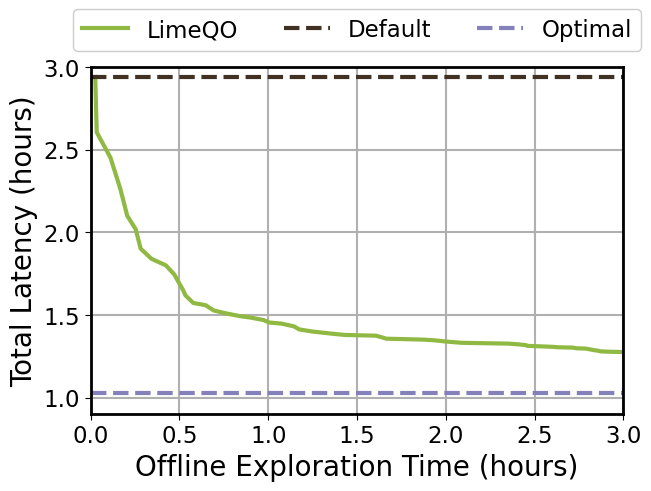

In [15]:
import matplotlib.pyplot as plt

linewidth=3
markersize=10
gridwidth=1.5
bwith=2
ticks_fontsize = 16.5
label_fontsize = 20
fontweight='normal'
markeredgecolor = 'k'
color_scheme = [
    "#4995c6",
    "#d47628",
    "#8fb943",
    "#d15c6b",
    "#8481ba",
    "#413123",
    "#ffdb58",
    "#a5a5a5",
    "#acbfea",
]

line_styles = ['-', '--', '-.', ':']

fig, ax = plt.subplots(1,1, constrained_layout=True)

ax.spines['bottom'].set_linewidth(bwith)
ax.spines['left'].set_linewidth(bwith)
ax.spines['top'].set_linewidth(bwith)
ax.spines['right'].set_linewidth(bwith)
ax.tick_params(axis='x', length=4, labelsize=ticks_fontsize)
ax.tick_params(axis='y', length=4, labelsize=ticks_fontsize)
ax.grid(linewidth=gridwidth)

execution_time_list_hours = [time / 3600 for time in execution_time_list]
total_latency_list_hours = [latency / 3600 for latency in total_latency_list]
ax.plot(execution_time_list_hours, total_latency_list_hours, color = color_scheme[2], label='LimeQO', linestyle=line_styles[0],  linewidth=linewidth)

ax.axhline(default_time/3600, label='Default', color = color_scheme[5], linestyle=line_styles[1], linewidth=linewidth) # PG
ax.axhline(opt_time/3600, label='Optimal' ,color = color_scheme[4], linestyle=line_styles[1], linewidth=linewidth) # Optimal

ax.legend(framealpha=1,fontsize=ticks_fontsize, loc='upper center',ncol=3, bbox_to_anchor=(0.5, 1.2))
ax.grid('--')
ax.set_xlim(-0, 3)
ax.set_ylim(0.9, 3)
ax.set_yticks([1.0, 1.5, 2.0, 2.5,3.0], [1.0, 1.5, 2.0, 2.5,3.0])
ax.set_ylabel('Total Latency (hours)', fontsize=label_fontsize)
ax.set_xlabel('Offline Exploration Time (hours)', fontsize=label_fontsize)

plt.savefig("fig/limeqo.png", bbox_inches='tight', dpi=300)